Количество изображений: 2594
Количество масок: 2594


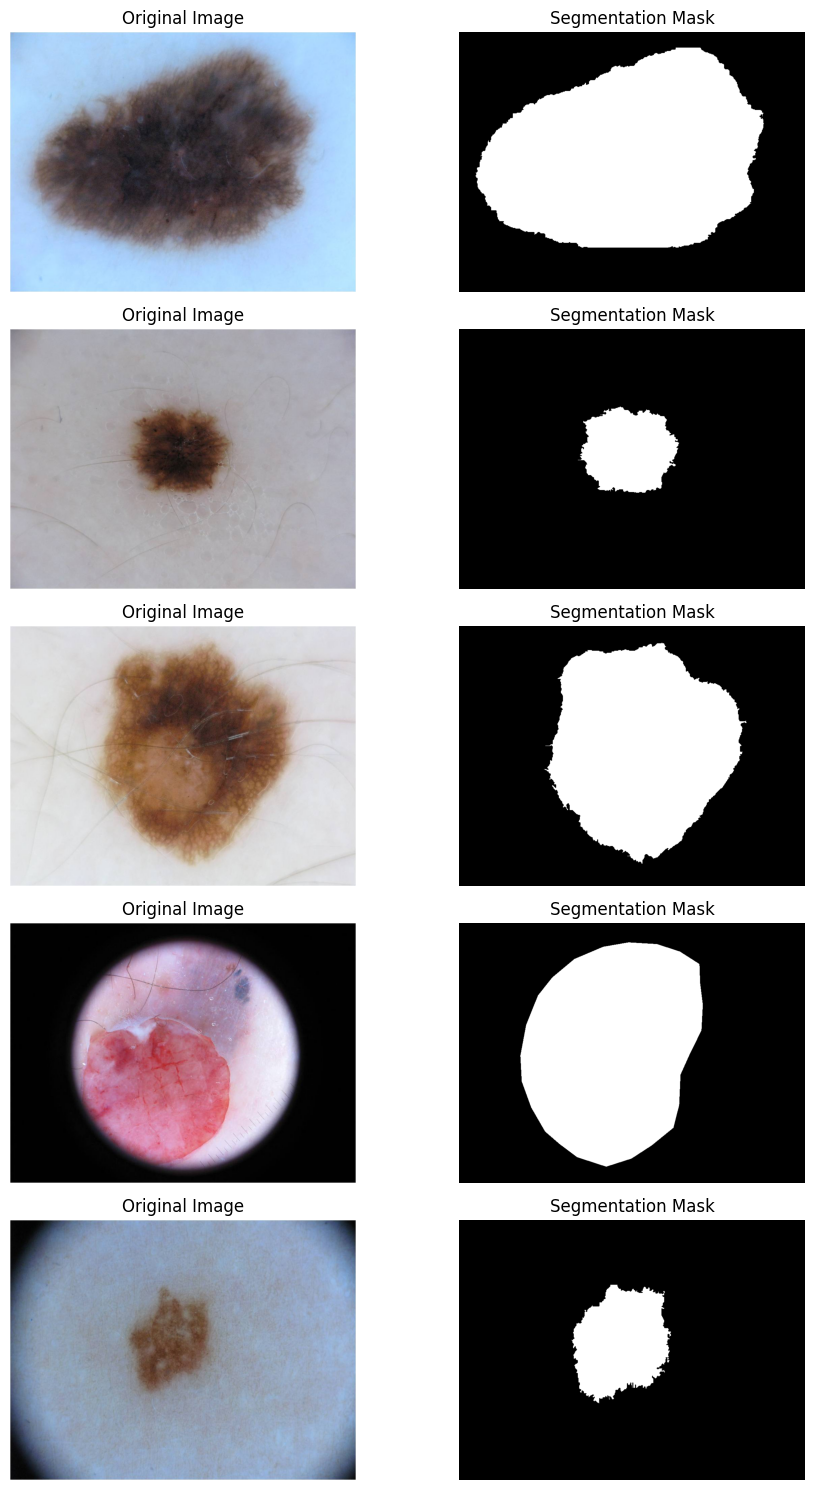

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from glob import glob

# Указываем пути к изображениям и маскам
IMAGE_PATH = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input"
MASK_PATH = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth"

# Получаем списки файлов
image_files = sorted(glob(os.path.join(IMAGE_PATH, "*.jpg")))
mask_files = sorted(glob(os.path.join(MASK_PATH, "*.png")))

# Проверяем количество файлов
print(f"Количество изображений: {len(image_files)}")
print(f"Количество масок: {len(mask_files)}")

# Визуализация нескольких изображений и их масок
def plot_samples(image_paths, mask_paths, num_samples=5):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))
    
    for i in range(num_samples):
        img = cv2.imread(image_paths[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_paths[i], cv2.IMREAD_GRAYSCALE)

        axes[i, 0].imshow(img)
        axes[i, 0].axis("off")
        axes[i, 0].set_title("Original Image")

        axes[i, 1].imshow(mask, cmap="gray")
        axes[i, 1].axis("off")
        axes[i, 1].set_title("Segmentation Mask")

    plt.tight_layout()
    plt.show()

plot_samples(image_files, mask_files, num_samples=5)


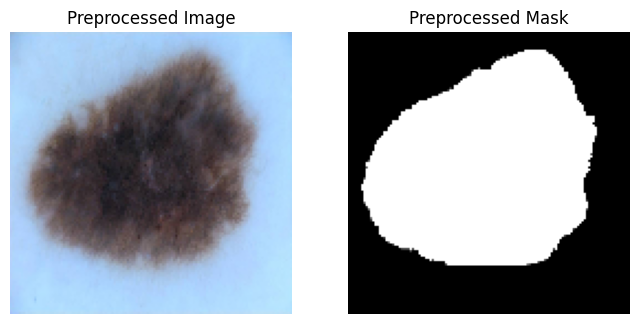

In [7]:
IMG_SIZE = (128, 128)  # Размер изображений для нейросети

def preprocess_image(image_path):
    """ Загрузка, изменение размера и нормализация изображения """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Перевод в RGB
    img = cv2.resize(img, IMG_SIZE)  # Изменение размера
    img = img / 255.0  # Нормализация
    return img

def preprocess_mask(mask_path):
    """ Загрузка, изменение размера и бинаризация маски """
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, IMG_SIZE)  # Изменение размера
    mask = mask / 255.0  # Нормализация (чтобы значения были от 0 до 1)
    mask = np.expand_dims(mask, axis=-1)  # Добавляем канал для совместимости с моделью
    return mask

# Проверим работу предобработки на одном изображении и маске
sample_img = preprocess_image(image_files[0])
sample_mask = preprocess_mask(mask_files[0])

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(sample_img)
ax[0].axis("off")
ax[0].set_title("Preprocessed Image")

ax[1].imshow(sample_mask.squeeze(), cmap="gray")
ax[1].axis("off")
ax[1].set_title("Preprocessed Mask")

plt.show()


In [8]:
from sklearn.model_selection import train_test_split

# Разделяем данные на train/val (80% / 20%)
train_images, val_images, train_masks, val_masks = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

print(f"Тренировочных изображений: {len(train_images)}, Валидационных: {len(val_images)}")


Тренировочных изображений: 2075, Валидационных: 519


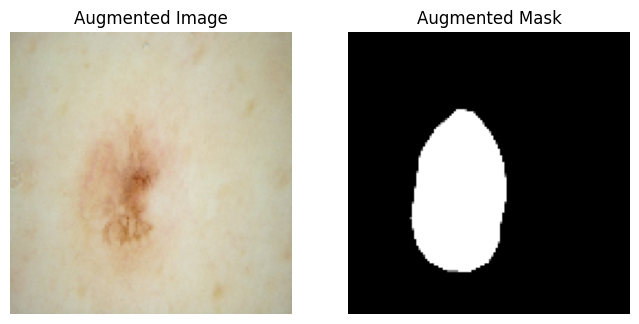

In [9]:
import tensorflow as tf
import cv2

# Функция для загрузки и предобработки изображения
def load_data(image_path, mask_path):
    image_path = image_path.numpy().decode("utf-8")  # Преобразуем tf.Tensor в строку
    mask_path = mask_path.numpy().decode("utf-8")

    img = preprocess_image(image_path)
    mask = preprocess_mask(mask_path)
    return img, mask

# Обертка для использования с `tf.data.Dataset`
def load_data_tf(image_path, mask_path):
    img, mask = tf.py_function(func=load_data, inp=[image_path, mask_path], Tout=[tf.float32, tf.float32])
    img.set_shape((128, 128, 3))
    mask.set_shape((128, 128, 1))
    return img, mask

# Функция для аугментации (вращение, сдвиг, отражение)
def augment(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    
    return image, mask

# Функция для создания датасета
def create_dataset(image_paths, mask_paths, batch_size=8, augment_data=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_data_tf, num_parallel_calls=tf.data.AUTOTUNE)

    if augment_data:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Пересоздаем датасеты
train_dataset = create_dataset(train_images, train_masks, batch_size=16, augment_data=True)
val_dataset = create_dataset(val_images, val_masks, batch_size=16, augment_data=False)

# Проверим одну картинку
for img, mask in train_dataset.take(1):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(img[0].numpy())
    ax[0].axis("off")
    ax[0].set_title("Augmented Image")

    ax[1].imshow(mask[0].numpy().squeeze(), cmap="gray")
    ax[1].axis("off")
    ax[1].set_title("Augmented Mask")

    plt.show()
    break


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2

# Функция создания свёрточного блока (Conv -> BatchNorm -> ReLU)
def conv_block(x, num_filters):
    x = layers.Conv2D(num_filters, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(num_filters, (3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    return x



def build_unet_mobilenet(input_shape=(128, 128, 3)):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights="/kaggle/input/mobileunet-from-google/keras/default/1/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_128_no_top.h5")
    #base_model = MobileNetV2('/kaggle/input/mobileunet-from-google/keras/default/1/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_128_no_top.h5')
    inputs = base_model.input

    # Encoder
    skip_connections = [
        base_model.get_layer("block_1_expand_relu").output,  
        base_model.get_layer("block_3_expand_relu").output,  
        base_model.get_layer("block_6_expand_relu").output,  
        base_model.get_layer("block_13_expand_relu").output  
    ]
    
    x = base_model.output
    
    # Bottleneck
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(x)

    # Decoder: больше upsampling, чтобы вернуть 128x128
    for i, skip in enumerate(reversed(skip_connections)):
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.concatenate([x, skip])
        x = layers.Conv2D(256 // (2**i), (3, 3), activation="relu", padding="same")(x)

    # Дополнительные UpSampling для возвращения 128x128
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)

    # Выходной слой
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid", padding="same")(x)

    model = Model(inputs, outputs)
    return model




In [11]:
import tensorflow.keras.backend as K

# Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# IoU (Jaccard Index)
def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


In [12]:
# Используем новую модель
model = build_unet_mobilenet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="binary_crossentropy", 
              metrics=["accuracy", dice_coefficient, iou])
  

# Выведем архитектуру
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 11,392,097 (43.46 MB)

 Trainable params: 11,357,985 (43.33 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Создаем директорию для сохранения модели
checkpoint_path = "best_model.h5.keras"

# Колбэки
callbacks = [
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor="val_loss", mode="min"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

# Количество эпох
EPOCHS = 10

# Обучение модели
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 485s 3s/step - accuracy: 0.8528 - dice_coefficient: 0.5213 - iou: 0.3969 - loss: 0.4001 - val_accuracy: 0.8581 - val_dice_coefficient: 0.5416 - val_iou: 0.3729 - val_loss: 0.3313 - learning_rate: 0.0010
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 440s 3s/step - accuracy: 0.9460 - dice_coefficient: 0.8103 - iou: 0.6836 - loss: 0.1378 - val_accuracy: 0.8085 - val_dice_coefficient: 0.4156 - val_iou: 0.2634 - val_loss: 0.4021 - learning_rate: 0.0010
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 458s 4s/step - accuracy: 0.9521 - dice_coefficient: 0.8321 - iou: 0.7149 - loss: 0.1205 - val_accuracy: 0.8741 - val_dice_coefficient: 0.5667 - val_iou: 0.3963 - val_loss: 0.3174 - learning_rate: 0.0010
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 447s 3s/step - accuracy: 0.9547 - dice_coefficient: 0.8403 - iou: 0.7268 - loss: 0.1122 - val_accuracy: 0.8728 - val_dice_coefficient: 0.5578 - val_iou: 0.3882 - val_loss: 0.3141 - learning_rate: 0.0010
Epoch 5/10
130/130 ━━━━━━━━━

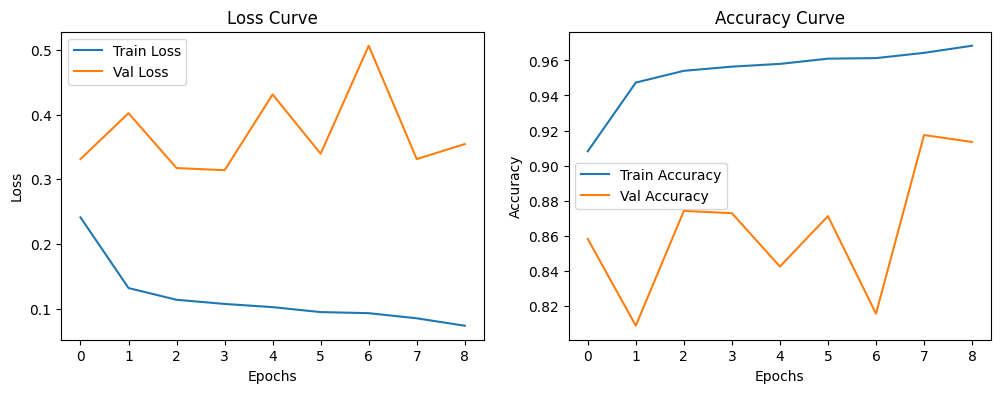

In [14]:
import matplotlib.pyplot as plt

# Визуализируем потери
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

# Визуализируем точность
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()
